# Log AutoGen Group Chat

[AutoGen](https://microsoft.github.io/autogen/0.2/) is an innovative open-source framework designed to streamline the development of AI agents capable of cooperative task-solving. Key features include support for large language models (LLMs), agent conversation capabilities, and both autonomous and human-assisted workflows. AutoGen is essential for building next-generation LLM applications, simplifying the orchestration and optimization of complex multi-agent conversations and boosting the performance of LLMs.

The Group Chat feature of AutoGen allows developers to customize agent interactions by defining conversation patterns and workflows. This customization is crucial as it enables precise control over the dialogue dynamics among agents, making development less cumbersome and more efficient. Tracking these interactions is vital to refining the agent's performance and ensuring the successful deployment of sophisticated multi-agent systems.

This tutorial demonstrates how we can build multi-agent system with AutoGen Group Chat and trace them with [Weave](../../introduction.md).

NOTE: This example refers to an example in [AutoGen documentation](https://microsoft.github.io/autogen/0.2/docs/notebooks/agentchat_groupchat_research/).


## Installing the Dependencies

We need the following libraries for this tutorial:
- [AutoGen](https://microsoft.github.io/autogen/0.2/) to create multi-agent system.
- [Weave](../../introduction.md) to track our LLM workflow and evaluate our prompting strategies.


In [ ]:
!pip install -qU autogen-agentchat~=0.2 weave wandb

In [ ]:
import os

import autogen
import wandb
from google.colab import userdata

import weave
from weave import Model

We set `WANDB_API_KEY` in our environment variable so that we may easily login with `wandb.login()` (this should be given to the colab as a secret).
We set the project in W&B we want to log this into in `name_of_wandb_project`.

**NOTE**: `name_of_wandb_project` may also be in the format of `{team_name}/{project_name}` to specify a team to log the traces into.
We then fetch a weave client by calling weave.init()

Since we'll be using the [OpenAI API](https://openai.com/index/openai-api/), we will also need an OpenAI API key. You can [sign up](https://platform.openai.com/signup) on the OpenAI platform to get your own API key. (this should be given to the colab as a secret too)


In [ ]:
os.environ["WANDB_API_KEY"] = userdata.get("WANDB_API_KEY")
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

wandb.login()
name_of_wandb_project = "autogen_group_chat"
weave.init(name_of_wandb_project)

## Group Chat with Weave Model
In GroupChat, we can customize the speaker selection by passing a function to the GroupChat object.
We define the following agents to do a survey about AI safety.

* Admin: Human in the loop to approve or terminate the process.
* Planner: Give a plan.
* Engineer: Retrieve papers from the internet by writing code.
* Executor: Execute the code.
* Scientist: Read the papers and get insights from them.
* Critic: Double check plan, claims, and code from other agents and provide feedback.

To manage GroupChat version, we will define the above Group Chat manager with [Weave Model](https://weave-docs.wandb.ai/guides/core-types/models). Weave Model is a combination of data and code that defines how the model operates. By structuring your code to be compatible with this API, you benefit from a structured way to version your application so you can more systematically keep track of your experiments.

To create a model in Weave, you need to inherit `Weave Model` class, define attributes and prepare a predict function with `@weave.op()` decorator.

In [ ]:
class GroupChat(Model):
    max_round: int
    user_proxy_sys_prompt: str
    engineer_sys_prompt: str
    scientist_sys_prompt: str
    planner_sys_prompt: str
    executor_sys_prompt: str
    critic_sys_prompt: str

    @weave.op()
    def predict(self, message: str) -> dict:
        gpt4o_config = {
            "cache_seed": 0,
            "temperature": 0,
            "config_list": [
                {"model": "gpt-4o", "api_key": os.environ["OPENAI_API_KEY"]}
            ],
            "timeout": 120,
        }

        user_proxy = autogen.UserProxyAgent(
            name="Admin",
            system_message=self.user_proxy_sys_prompt,
            code_execution_config=False,
        )
        engineer = autogen.AssistantAgent(
            name="Engineer",
            llm_config=gpt4o_config,
            system_message=self.engineer_sys_prompt,
        )
        scientist = autogen.AssistantAgent(
            name="Scientist",
            llm_config=gpt4o_config,
            system_message=self.scientist_sys_prompt,
        )
        planner = autogen.AssistantAgent(
            name="Planner",
            system_message=self.planner_sys_prompt,
            llm_config=gpt4o_config,
        )
        executor = autogen.UserProxyAgent(
            name="Executor",
            system_message=self.executor_sys_prompt,
            human_input_mode="NEVER",
            code_execution_config={
                "last_n_messages": 3,
                "work_dir": "paper",
                "use_docker": False,
            },
        )
        critic = autogen.AssistantAgent(
            name="Critic",
            system_message=self.critic_sys_prompt,
            llm_config=gpt4o_config,
        )

        groupchat = autogen.GroupChat(
            agents=[user_proxy, engineer, scientist, planner, executor, critic],
            messages=[],
            max_round=self.max_round,
        )
        manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=gpt4o_config)
        output = user_proxy.initiate_chat(
            manager,
            message=message,
        )
        return {"output": output}

Then, we define propots for each agent and build an instance the above model by passing attribute values.


In [ ]:
user_proxy_sys_prompt = "A human admin. Interact with the planner to discuss the plan. Plan execution needs to be approved by this admin."
engineer_sys_prompt = """Engineer. You follow an approved plan. You write python/shell code to solve tasks. Wrap the code in a code block that specifies the script type. The user can't modify your code. So do not suggest incomplete code which requires others to modify. Don't use a code block if it's not intended to be executed by the executor.
      Don't include multiple code blocks in one response. Do not ask others to copy and paste the result. Check the execution result returned by the executor.
      If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
      """
scientist_sys_prompt = "Scientist. You follow an approved plan. You are able to categorize papers after seeing their abstracts printed. You don't write code."
planner_sys_prompt = """Planner. Suggest a plan. Revise the plan based on feedback from admin and critic, until admin approval.
      The plan may involve an engineer who can write code and a scientist who doesn't write code.
      Explain the plan first. Be clear which step is performed by an engineer, and which step is performed by a scientist.
      """
executor_sys_prompt = (
    "Executor. Execute the code written by the engineer and report the result."
)
critic_sys_prompt = "Critic. Double check plan, claims, and code from other agents and provide feedback. Check whether the plan includes adding verifiable info such as source URL."

model = GroupChat(
    user_proxy_sys_prompt=user_proxy_sys_prompt,
    engineer_sys_prompt=engineer_sys_prompt,
    scientist_sys_prompt=scientist_sys_prompt,
    planner_sys_prompt=planner_sys_prompt,
    executor_sys_prompt=executor_sys_prompt,
    critic_sys_prompt=critic_sys_prompt,
    max_round=50,
)

## Tacking of Group Chat using Weave

Weave is currently integrated with OpenAI. Including `weave.init` at the start of our code lets us automatically capture traces for the openai python library. Check out the Weave integration [docs for OpenAI](https://weave-docs.wandb.ai/guides/integrations/openai) to learn more.
In this example, we use gpt-4o in each agent, and we can automatically track the conversations between agents!

We can call the defined model with the following code.
This will track the model settings along with the inputs and outputs.

In [ ]:
model.predict(
    "find papers on AI safety from arxiv in the past three months, pick up three important points"
)

When we click on the URL for Weave, we can see that the execution is being traced as follows.  On the Traces page, we can check the input and output.

Weave provides integration with OpenAI's API, which allows costs to be automatically calculated. So, we can confirm cost and latency are also displayed on the far right.


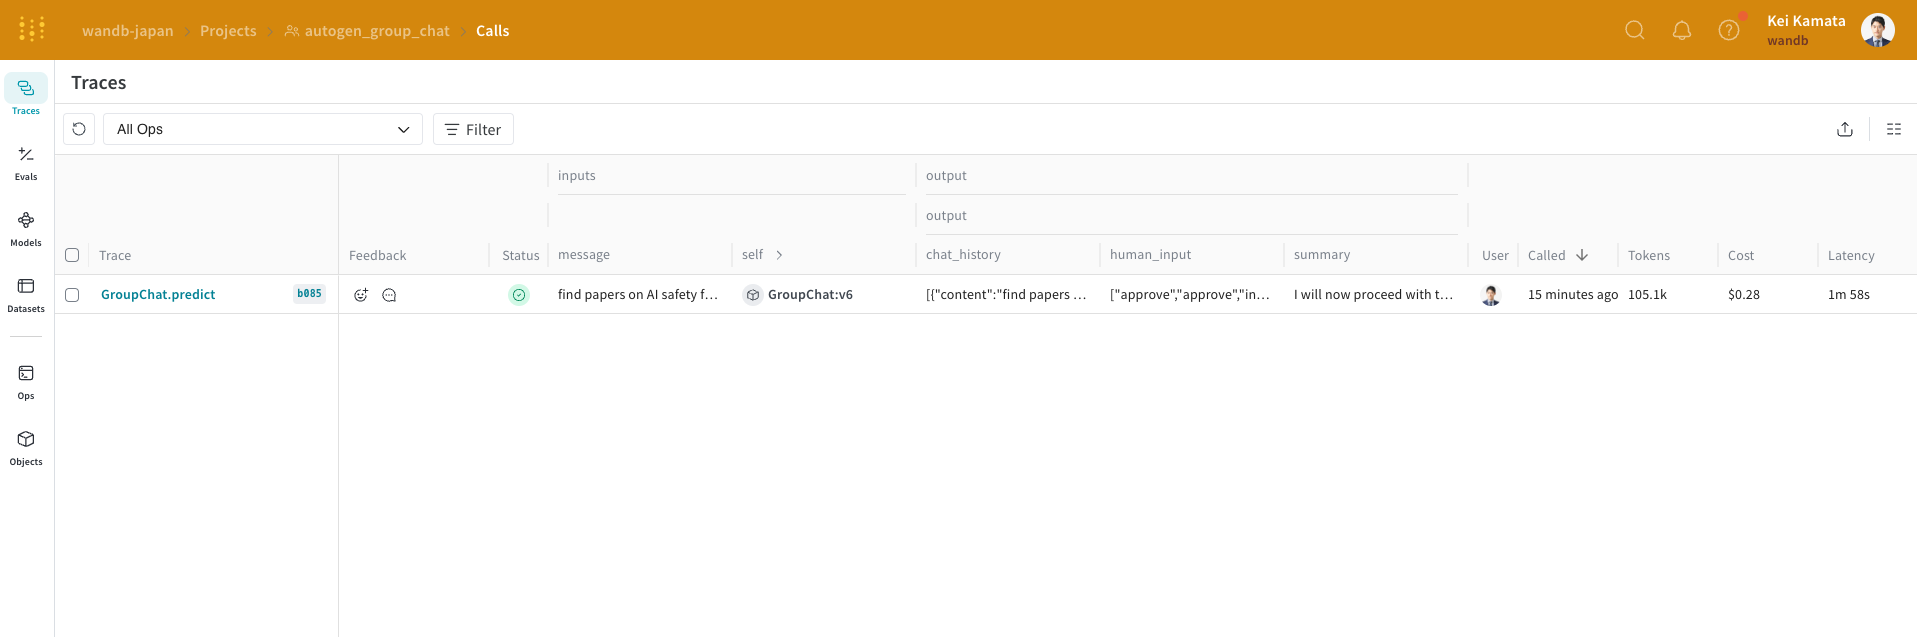



By clicking on a `GroupChat:vX`, you can view the Group Chat used in the execution. Every time we make a change to our GroupChat class, we automatically increment the version in Weave.

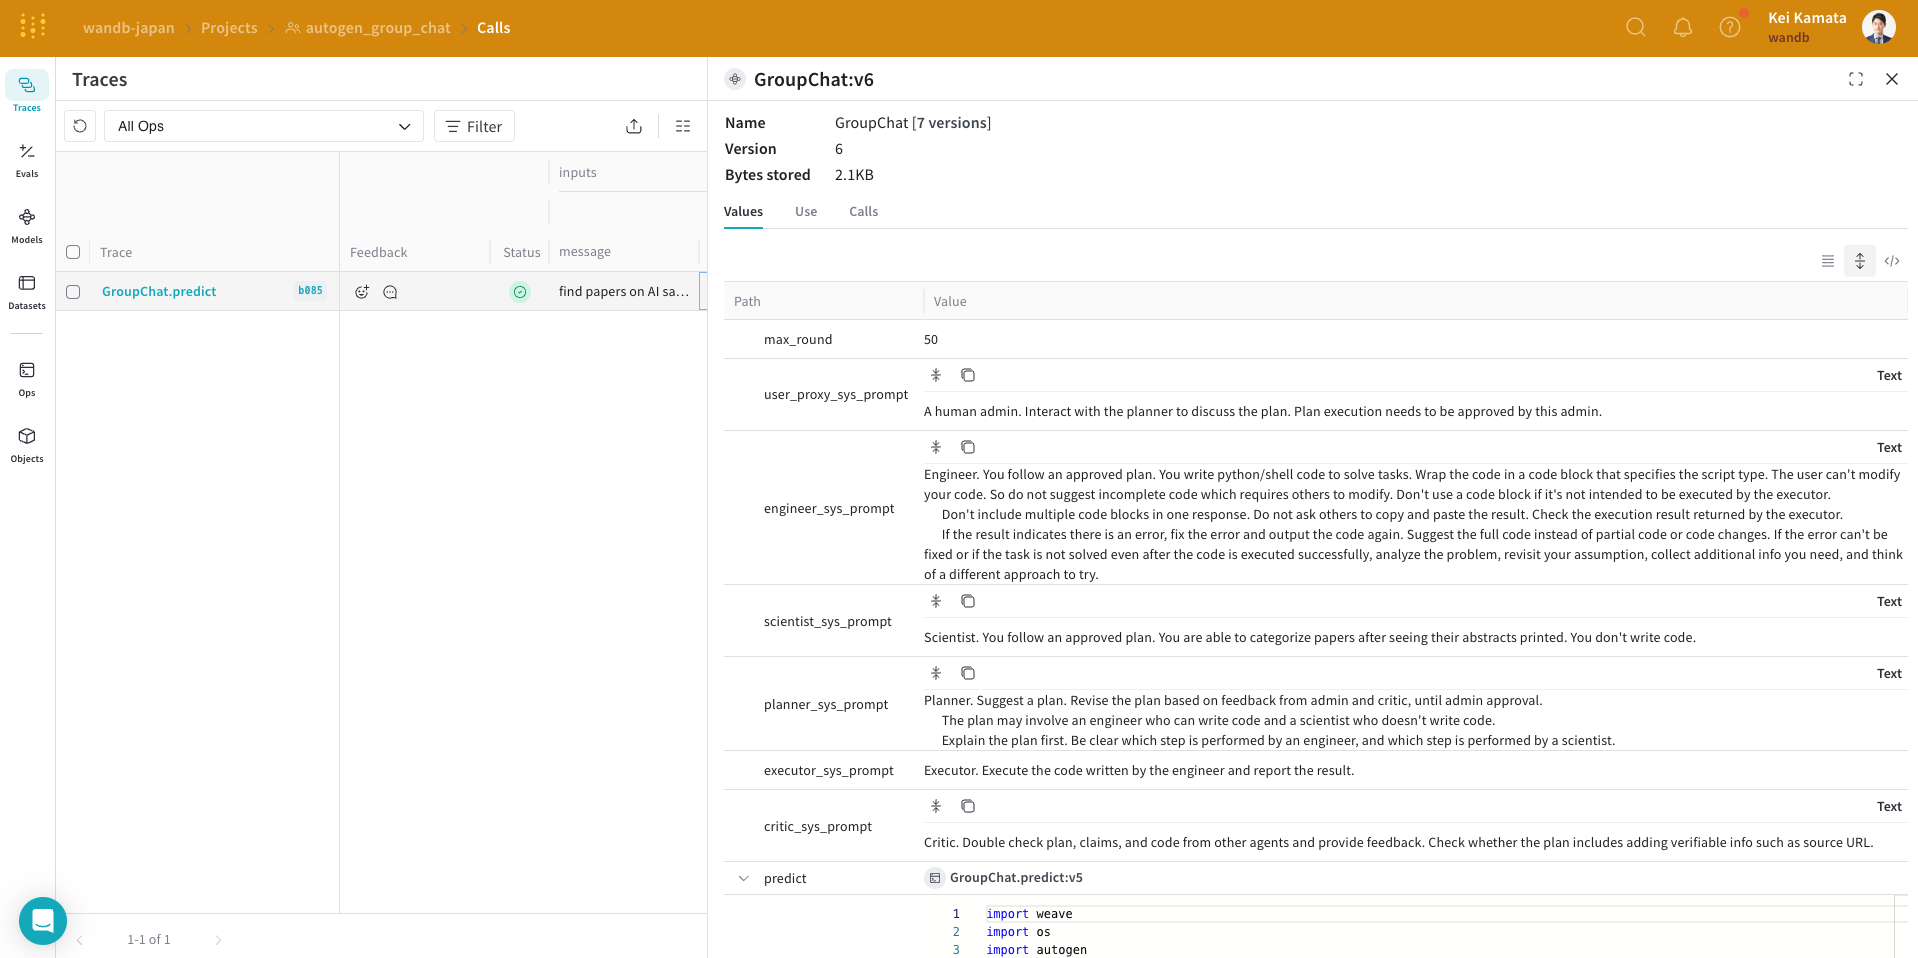

By clicking on a line, we can see the intermediate processes executed within the group chat. This trace allows us to understand what inputs each agent receives and what functions they execute.

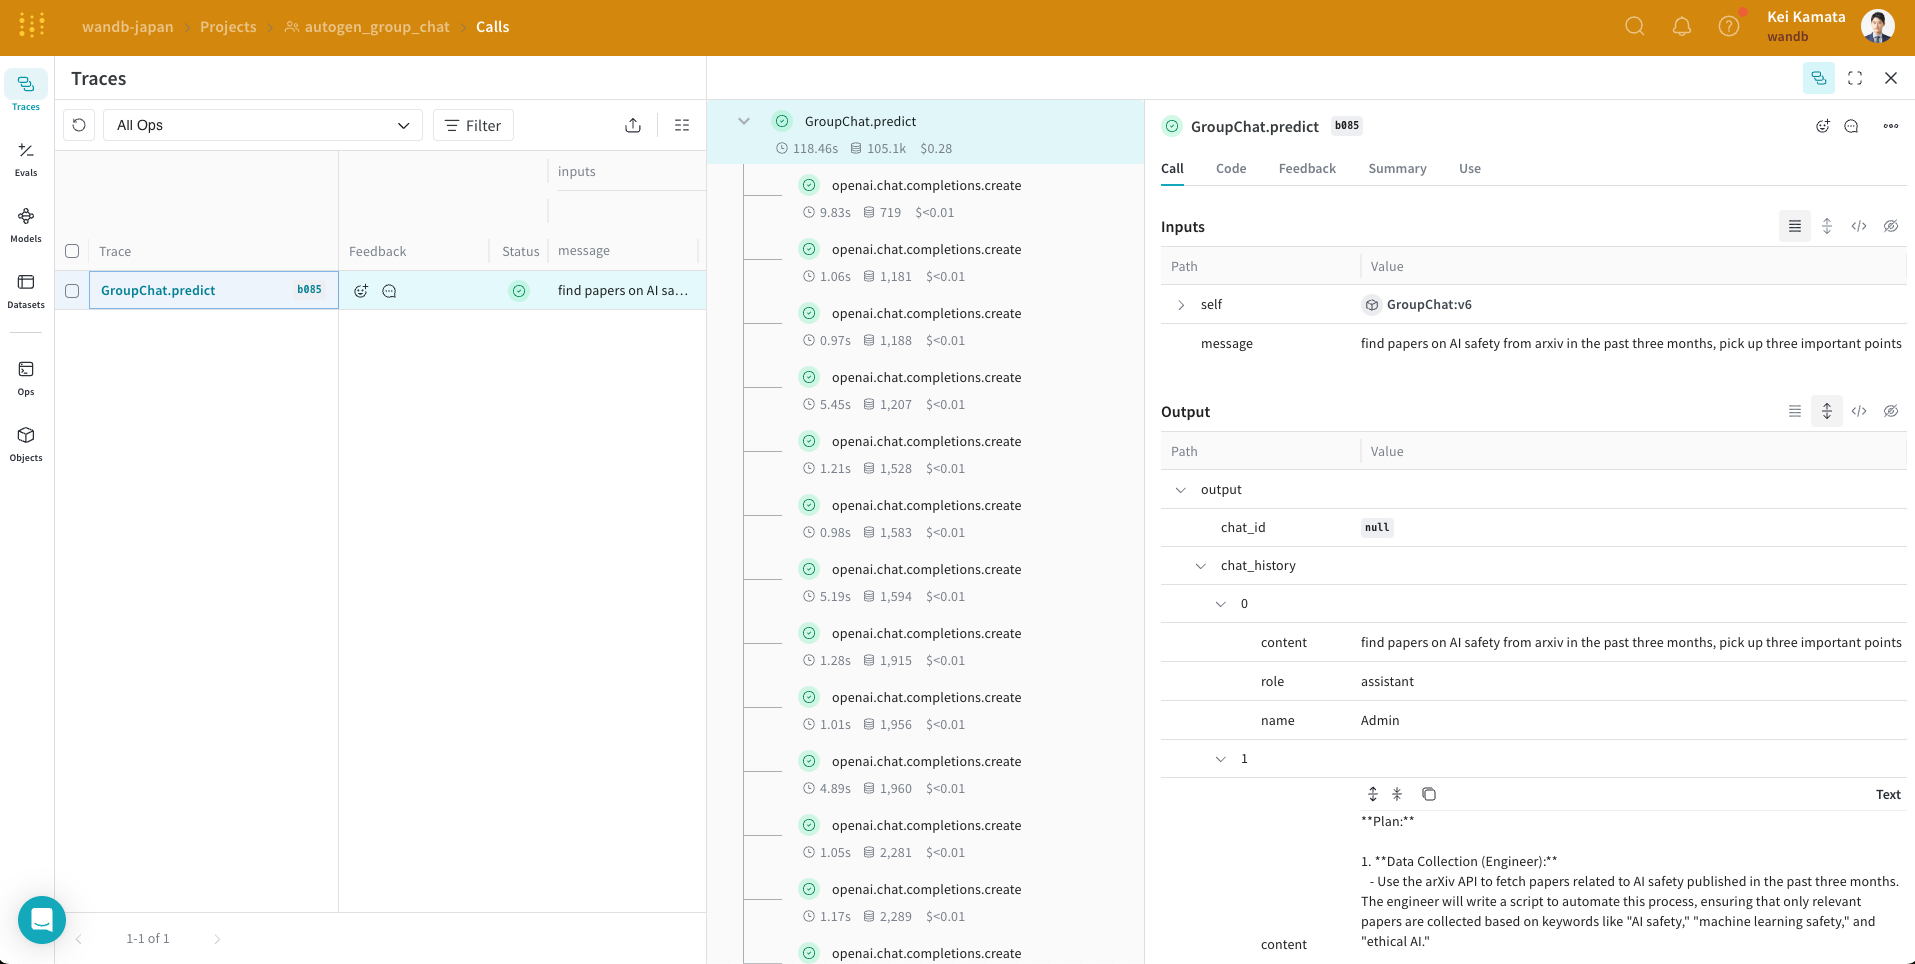

Additionally, Weave can display the chat in a clear and comprehensible manner, making it easy to review the internal conversations. By using weave, we can track a multi-agent system built with AutoGen efficiently without adding many extra lines of code

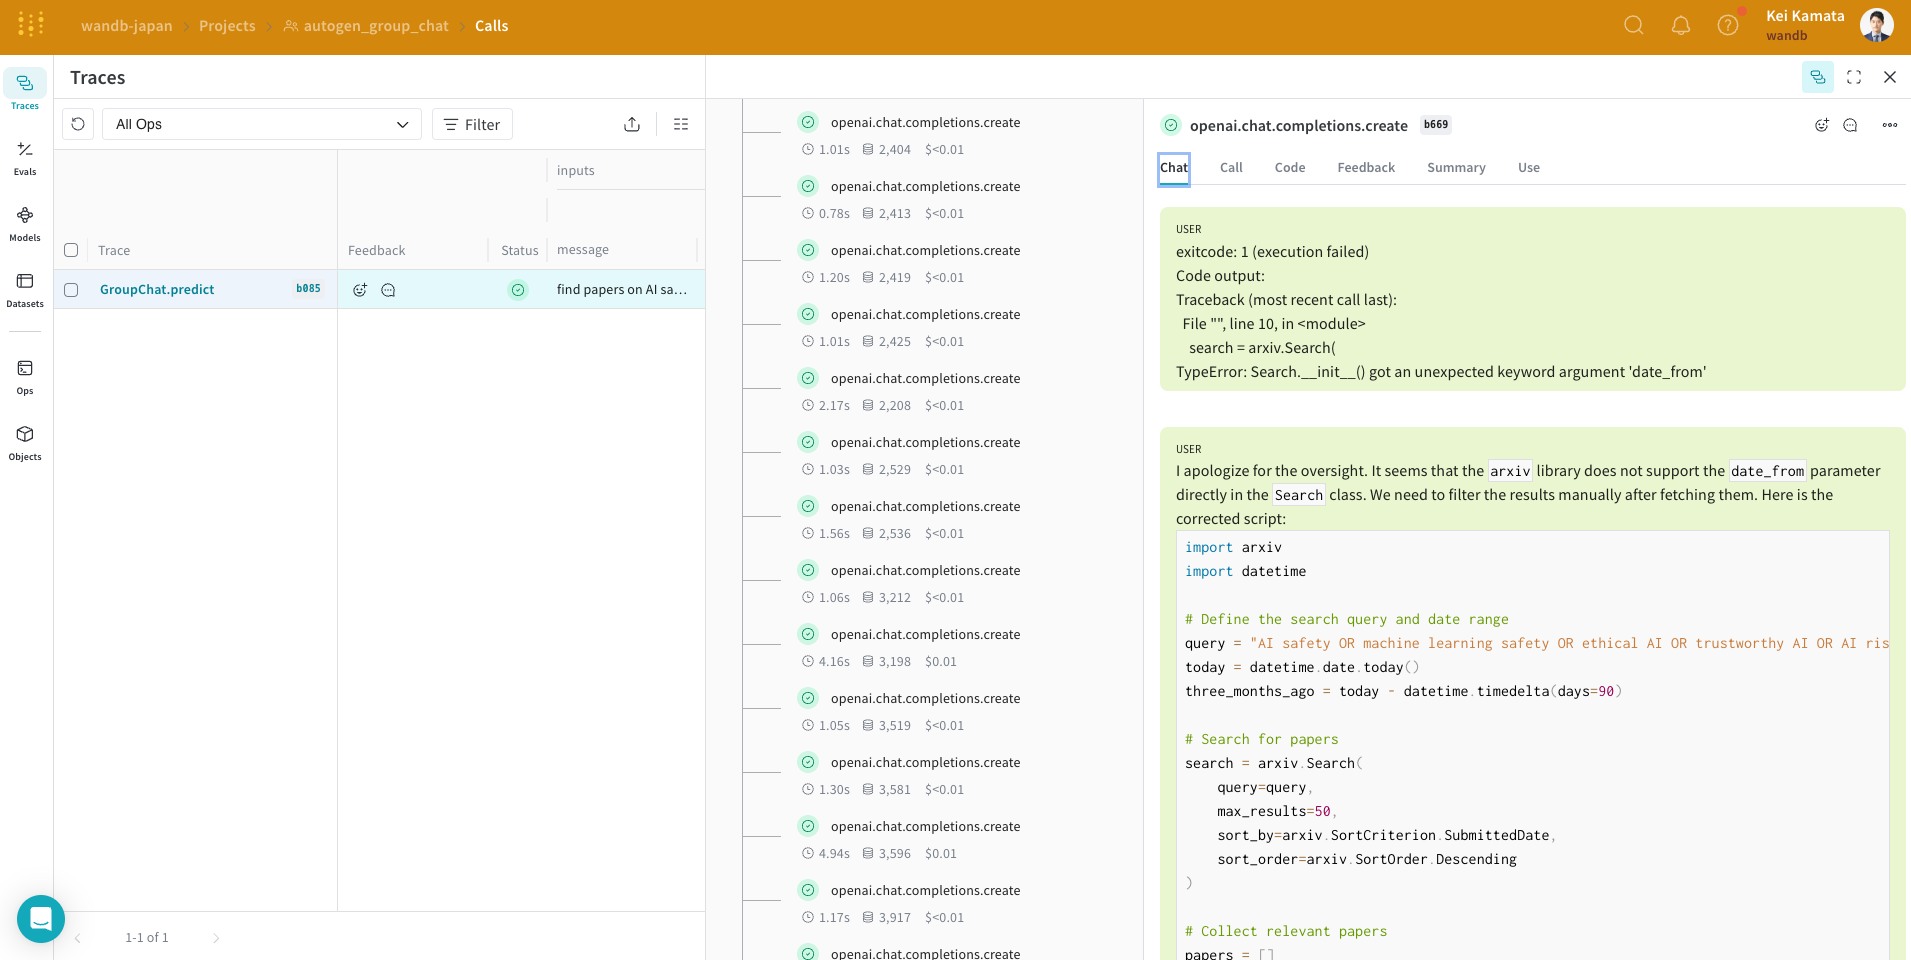

## Conclusion
In this tutorial, we learned how to conveniently develop a multi-agent system using AutoGen and by instrumenting Weave for tracking inputs, final outputs, and intermediate steps.
We've shown how to:
* Trace the agents in AugoGen automatically with Weave by utilizing the integration of OpenAI
* Manage Group Chat manager with Weave Model
* Confirm the intermediate process and chat in Weave UI.

For more information on Weave and its capabilities, check out the [Weave documentation](https://weave-docs.wandb.ai/).